In [5]:
import os
import pickle
from abc import ABC
from collections import Counter

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
def JS_divergence(p, q):
    M = (p + q) / 2
    return 0.5 * scipy.stats.entropy(p, M, base=2) + 0.5 * scipy.stats.entropy(q, M, base=2)

In [23]:
class Aligner(ABC):
    def __init__(self, method, source, target, w2id, id2w, mtxA, mtxB, trainvoc):
        self.method = method
        self.src = source
        self.tgt = target
        self.w2idA = w2id
        self.id2wB = id2w
        self.mtxA = mtxA
        self.mtxB = mtxB
        self.anchors = trainvoc

    def translate_mtx(self, mtx):
        """
        MTX -> MTX
        """
        pass

    def encode_input(self, words):
        """
        [STRING] -> MTX
        """
        embs = [self.mtxA[self.w2idA[w], :] for w in words]
        return np.vstack(embs)

    def decode_output(self, mtx, k=1):
        """
        MTX -> [[STRING]]
        """
        similarities = cosine_similarity(mtx, self.mtxB)
        most_similar = np.argsort(similarities, axis=1)[:, ::-1]
        topsims = np.sort(similarities, axis=1)[:, ::-1][:, :k]
        res = [[self.id2wB[i] for i in row[:k]] for row in most_similar]
        return res, topsims

    def translate_word(self, word, k=1):
        """
        STRING -> STRING
        """
        encoding = self.encode_input([word])
        translated = self.translate_mtx(encoding)
        decoded = self.decode_output(translated, k=k)
        return decoded[0][:k]

    def translate_words(self, words, k=1):
        """
        [STRING] -> [STRING]
        """
        encoding = self.encode_input(words)
        translated = self.translate_mtx(encoding)
        decoded, simscores = self.decode_output(translated, k=k)
        return decoded, simscores


class CCAAligner(Aligner):
    def set_params(self, cca):
        self.cca = cca

    def translate_mtx(self, mtx):
        return mtx

    def translate_word(self, word, k=1):
        tmpA = self.mtxA
        tmpB = self.mtxB
        self.mtxA, self.mtxB = self.cca.transform(tmpA, tmpB)
        res = super().translate_word(word, k=k)
        self.mtxA = tmpA
        self.mtxB = tmpB
        return res

    def translate_words(self, words, k=1):
        tmpA = self.mtxA
        tmpB = self.mtxB
        self.mtxA, self.mtxB = self.cca.transform(tmpA, tmpB)
        res, simscores = super().translate_words(words, k=k)
        self.mtxA = tmpA
        self.mtxB = tmpB
        return res, simscores


class SVDAligner(Aligner):
    def set_params(self, T):
        self.T = T

    def translate_mtx(self, mtx):
        return mtx.dot(self.T)


def align_cca(source, target):
    N_dims = source.shape[1]
    cca = CCA(n_components=N_dims, max_iter=2000)
    cca.fit(source, target)
    return cca


def align_svd(source, target):
    product = np.matmul(source.transpose(), target)
    U, s, V = np.linalg.svd(product)
    T = np.matmul(U, V)
    return T


def get_cca_aligner(model_a, model_b, anchorlist):
    # get wordmaps
    awords = list(sorted(list(model_a.wv.key_to_index)))
    bwords = list(sorted(list(model_b.wv.key_to_index)))
    w2idA = {w: i for i, w in enumerate(awords)}
    id2wA = {i: w for i, w in enumerate(awords)}
    w2idB = {w: i for i, w in enumerate(bwords)}
    id2wB = {i: w for i, w in enumerate(bwords)}

    # build the base matrices
    a_mtx = np.vstack([model_a.wv[w] for w in awords])
    b_mtx = np.vstack([model_b.wv[w] for w in bwords])

    # get the anchors
    a_anchor = np.vstack([a_mtx[w2idA[w], :] for w in anchorlist])
    b_anchor = np.vstack([b_mtx[w2idB[w], :] for w in anchorlist])

    # compute CCA
    cca = align_cca(a_anchor, b_anchor)

    # build and return the aligner
    aligner = CCAAligner('cca', model_a, model_b, w2idA, id2wB, a_mtx, b_mtx, anchorlist)
    aligner.set_params(cca)
    return aligner


def get_svd_aligner(model_a, model_b, anchorlist):
    # get wordmaps
    awords = list(sorted(list(model_a.wv.vocab)))
    bwords = list(sorted(list(model_b.wv.vocab)))
    w2idA = {w: i for i, w in enumerate(awords)}
    w2idB = {w: i for i, w in enumerate(bwords)}
    id2wB = {i: w for i, w in enumerate(bwords)}

    # build the base matrices
    a_mtx = np.vstack([model_a.wv[w] for w in awords])
    b_mtx = np.vstack([model_b.wv[w] for w in bwords])
    print(a_mtx.shape, b_mtx.shape)

    # get the anchors
    a_anchor = np.vstack([a_mtx[w2idA[w], :] for w in anchorlist])
    b_anchor = np.vstack([b_mtx[w2idB[w], :] for w in anchorlist])

    # get the translation matrix
    T = align_svd(a_anchor, b_anchor)

    # build and return the aligner
    aligner = SVDAligner('svd', model_a, model_b, w2idA, id2wB, a_mtx, b_mtx, anchorlist)
    aligner.set_params(T)
    return aligner

In [14]:
stopWords_nltk = set(stopwords.words('english'))
stopWords_spc = {'those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am',
                 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing',
                 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount',
                 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it',
                 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby',
                 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that',
                 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would',
                 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without',
                 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may',
                 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise',
                 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s',
                 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say',
                 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless',
                 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become',
                 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be',
                 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about',
                 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming',
                 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often',
                 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re',
                 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we',
                 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after',
                 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere',
                 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has',
                 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each',
                 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re',
                 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither',
                 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards',
                 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below',
                 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve'}
stopWords_s = stopWords_spc | stopWords_nltk | STOPWORDS

In [15]:
model_general = gensim.models.Word2Vec.load(os.path.join('./models', 'general.model'))
model_nypost = gensim.models.Word2Vec.load(os.path.join('./models', 'nypost.model'))
model_cnn = gensim.models.Word2Vec.load(os.path.join('./models', 'cnn.model'))

In [16]:
vocab = list(sorted(list(model_general.wv.index_to_key)))
vocab = [w for w in vocab if w not in stopWords_s]
mtx = np.vstack([model_general.wv[w] for w in vocab])

clustering = KMeans(n_clusters=300).fit(mtx)
res = {}
t_align = {}
for c, w in zip(clustering.labels_, vocab):
    t_align[w] = c
    c = str(c)
    if c not in res:
        res[c] = []
    res[c].append(w)

In [31]:
def research_topic(keywords):
    cnn_path = f"CNN_{keywords}"
    for f_name in os.listdir("./data/CNN"):
        if f_name.startswith(cnn_path):
            break
    cnn_file = open(os.path.join("./data/CNN", f_name), 'r')

    nypost_path = f"nypost_{keywords}"
    for f_name in os.listdir("./data/nypost"):
        if f_name.startswith(nypost_path):
            break
    nypost_file = open(os.path.join("./data/nypost", f_name), 'r')

    word_intersec = []
    t_vec_cnn = np.zeros(300)
    df = pd.read_csv(cnn_file)
    all_cnn = 0
    for idx, row in df.iterrows():
        for st in sent_tokenize(str(row['text'])):
            sts_list = gensim.utils.simple_preprocess(st)
            hist = Counter(sts_list)
            for k in hist:
                num = t_align.get(k, -1)
                if num >= 0:
                    word_intersec.append(k)
                    all_cnn += hist[k]
                    t_vec_cnn[num] += hist[k]
    t_vec_cnn /= all_cnn

    t_vec_nypost = np.zeros(300)
    df = pd.read_csv(nypost_file)
    all_nypost = 0
    for idx, row in df.iterrows():
        for st in sent_tokenize(str(row['text'])):
            sts_list = gensim.utils.simple_preprocess(st)
            hist = Counter(sts_list)
            for k in hist:
                num = t_align.get(k, -1)
                if num >= 0:
                    word_intersec.append(k)
                    all_nypost += hist[k]
                    t_vec_nypost[num] += hist[k]
    t_vec_nypost /= all_nypost

    topic_js = JS_divergence(t_vec_nypost, t_vec_cnn)
    topic_cos = cosine_similarity(np.array(t_vec_nypost).reshape([1, -1]), np.array(t_vec_cnn).reshape([1, -1]))

    forward_cnn = pickle.load(open(os.path.join('./models', 'align_cnn.pkl'), 'rb'))
    forward_nypost = pickle.load(open(os.path.join('./models', 'align_nypost.pkl'), 'rb'))

    dis = []
    for wd in word_intersec:
        if wd in model_general.wv.key_to_index and wd in model_cnn.wv.key_to_index:
            vec_nypost = forward_nypost.translate_mtx(model_nypost.wv[wd])
            vec_cnn = forward_cnn.translate_mtx(model_cnn.wv[wd])
            cos_sim = cosine_similarity(np.array(vec_nypost).reshape([1, -1]), np.array(vec_cnn).reshape([1, -1]))
            dis.append(cos_sim)
    mean_c = np.mean(np.array(dis))

    return topic_js, topic_cos, mean_c, t_vec_cnn, t_vec_nypost

In [33]:
topics = ["attack", "Biden", "black", "China", "conflict", "crime", "democratic", "fair", "gun", "immigration",
          "invasion", "LGBT", "police", "protest", "refused", "republic", "Russia", "terror", "Trump", "UK", "ukraine",
          "US", "violence", "war"]

t_js_list = []
t_cos_list = []
mean_list = []
t_cnn = []
t_nypost = []

for t in topics:
    print(t)
    a, b, c, d, e = research_topic(t)
    t_js_list.append(a)
    t_cos_list.append(b)
    mean_list.append(c)
    t_cnn.append(d)
    t_nypost.append(e)

attack
Biden
black
China
conflict
crime
democratic
fair
gun
immigration
invasion
LGBT
police
protest
refused
republic
Russia
terror
Trump
UK
ukraine
US
violence
war


In [3]:
topics = ["attack", "Biden", "black", "China", "conflict", "crime", "democratic", "fair", "gun", "immigration",
          "invasion", "LGBT", "police", "protest", "refused", "republic", "Russia", "terror", "Trump", "UK", "ukraine",
          "US", "violence", "war"]
list(enumerate(topics))

[(0, 'attack'),
 (1, 'Biden'),
 (2, 'black'),
 (3, 'China'),
 (4, 'conflict'),
 (5, 'crime'),
 (6, 'democratic'),
 (7, 'fair'),
 (8, 'gun'),
 (9, 'immigration'),
 (10, 'invasion'),
 (11, 'LGBT'),
 (12, 'police'),
 (13, 'protest'),
 (14, 'refused'),
 (15, 'republic'),
 (16, 'Russia'),
 (17, 'terror'),
 (18, 'Trump'),
 (19, 'UK'),
 (20, 'ukraine'),
 (21, 'US'),
 (22, 'violence'),
 (23, 'war')]

In [39]:
other = [1, 2, 3, 6, 7, 9, 11, 15, 16, 18, 19, 21]
war = [10, 17, 20, 23]
violence = [0, 4, 5, 8, 12, 13, 14, 22]

,Unnamed: 0,mean_simi,JS_div,Cos_div,t_cnn,t_nypost
Unnamed: 0,,,,,,
attack,attack,0.001105,0.013820,[[0.96264682]],[0.00284189 0.00237982 0.00667972 0.00110277 0...,[2.46726543e-03 2.84823772e-03 6.51138031e-03 ...
Biden,Biden,0.002523,0.015581,[[0.9484526]],[2.99194910e-03 1.86096797e-03 6.18217990e-03 ...,[2.36729750e-03 2.66402960e-03 4.93668518e-03 ...
black,black,0.003573,0.013368,[[0.95378309]],[2.53576403e-03 2.36981402e-03 6.51616332e-03 ...,[1.86068395e-03 2.44374254e-03 7.27075451e-03 ...
China,China,0.003694,0.015156,[[0.94840032]],[2.32661602e-03 2.10653072e-03 6.88709781e-03 ...,[1.98689458e-03 2.26571721e-03 5.02334101e-03 ...
conflict,conflict,0.002684,0.006597,[[0.98366988]],[0.00224817 0.00222569 0.00570515 0.00174014 0...,[0.00263482 0.0029806 0.00602448 0.00172819 0...
crime,crime,0.001033,0.007998,[[0.97975819]],[4.93057744e-03 2.47166789e-03 7.02052988e-03 ...,[3.82291285e-03 2.93834775e-03 5.62571163e-03 ...
democratic,democratic,0.004632,0.015976,[[0.95484064]],[2.14754493e-03 3.34796894e-03 6.28861064e-03 ...,[3.12642561e-03 2.30410411e-03 5.05607424e-03 ...
fair,fair,0.003808,0.008109,[[0.97816194]],[2.73699540e-03 2.39598297e-03 7.13490254e-03 ...,[2.12683398e-03 2.60625795e-03 7.23266666e-03 ...
gun,gun,0.000393,0.009600,[[0.97341753]],[4.89751985e-03 2.75235773e-03 6.79871405e-03 ...,[3.39594114e-03 2.91617814e-03 6.14364184e-03 ...


In [16]:
df = pd.read_csv('./records.csv')
df.index = df['Unnamed: 0']
df.iloc[other]

,Unnamed: 0,mean_simi,JS_div,Cos_div,t_cnn,t_nypost
Unnamed: 0,,,,,,
Biden,Biden,0.002523,0.015581,[[0.9484526]],[2.99194910e-03 1.86096797e-03 6.18217990e-03 ...,[2.36729750e-03 2.66402960e-03 4.93668518e-03 ...
black,black,0.003573,0.013368,[[0.95378309]],[2.53576403e-03 2.36981402e-03 6.51616332e-03 ...,[1.86068395e-03 2.44374254e-03 7.27075451e-03 ...
China,China,0.003694,0.015156,[[0.94840032]],[2.32661602e-03 2.10653072e-03 6.88709781e-03 ...,[1.98689458e-03 2.26571721e-03 5.02334101e-03 ...
democratic,democratic,0.004632,0.015976,[[0.95484064]],[2.14754493e-03 3.34796894e-03 6.28861064e-03 ...,[3.12642561e-03 2.30410411e-03 5.05607424e-03 ...
fair,fair,0.003808,0.008109,[[0.97816194]],[2.73699540e-03 2.39598297e-03 7.13490254e-03 ...,[2.12683398e-03 2.60625795e-03 7.23266666e-03 ...
immigration,immigration,0.003370,0.007668,[[0.9771349]],[3.94832756e-03 2.20826716e-03 5.83327555e-03 ...,[3.08780128e-03 2.22401597e-03 5.41576743e-03 ...
LGBT,LGBT,0.001234,0.005792,[[0.98463235]],[5.02424820e-03 2.88636085e-03 5.91964823e-03 ...,[3.60799068e-03 2.79638240e-03 5.84560227e-03 ...
Russia,Russia,0.002004,0.020575,[[0.92913407]],[2.54053703e-03 1.91682289e-03 7.12615365e-03 ...,[1.89480912e-03 3.69886858e-03 5.24744407e-03 ...
Trump,Trump,0.004232,0.016220,[[0.89072097]],[2.36110980e-03 3.01162651e-03 6.95309145e-03 ...,[2.74123187e-03 2.52680214e-03 5.25289780e-03 ...


In [17]:
plt.figure(figsize=[10, 10])

other = [1, 2, 3, 6, 7, 9, 11, 16, 18, 19, 20, 21]
plt.scatter(np.array(df.iloc[other]['JS_div']), -np.array(df.iloc[other]['mean_simi']))
for i in other:
    plt.annotate(topics[i], (np.array(df['JS_div']), -np.array(df['mean_simi'])))
plt.xlabel('content sdiversity by JS divergence')
plt.ylabel('attitude sdiversity')

Text(0, 0.5, 'attitude sdiversity')

Error in callback <function _draw_all_if_interactive at 0x7f86b9fe4940> (for post_execute):


TypeError: only size-1 arrays can be converted to Python scalars

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1000x1000 with 1 Axes>

Text(0, 0.5, 'Ideological context diversity')

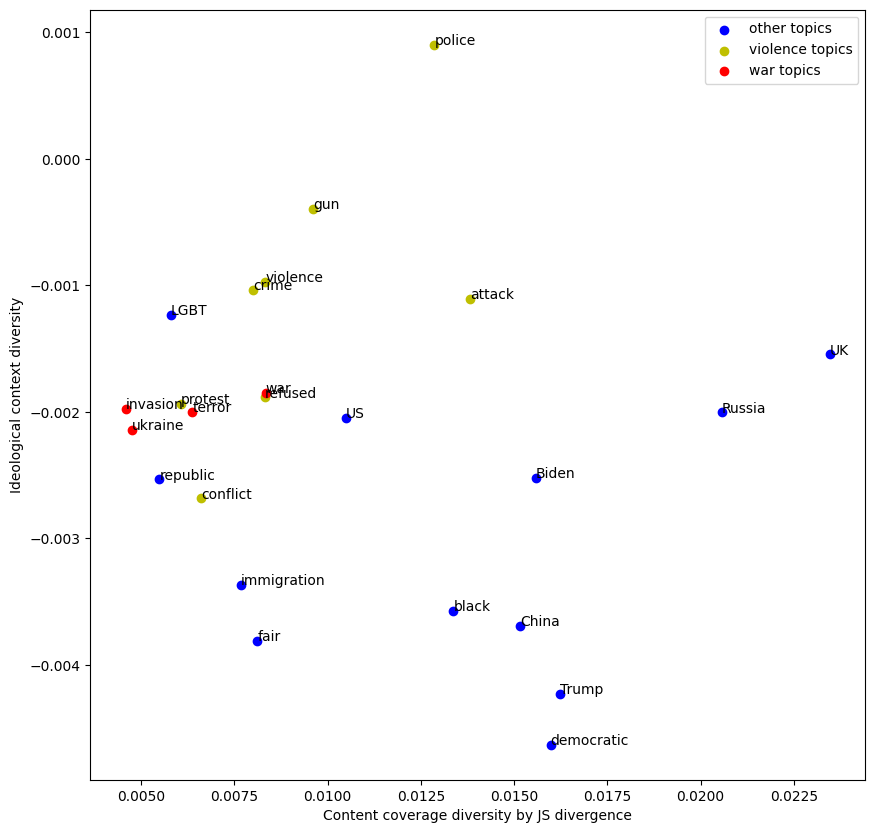

In [40]:
plt.figure(figsize=[10, 10])
plt.scatter(np.array(df.iloc[other]['JS_div']), -np.array(df.iloc[other]['mean_simi']), c='b', label='other topics')
plt.scatter(np.array(df.iloc[violence]['JS_div']), -np.array(df.iloc[violence]['mean_simi']), c='y',
            label='violence topics')
plt.scatter(np.array(df.iloc[war]['JS_div']), -np.array(df.iloc[war]['mean_simi']), c='r', label='war topics')
plt.legend()
for i in range(len(topics)):
    plt.annotate(topics[i], (df['JS_div'][i], -df['mean_simi'][i]))
plt.xlabel('Content coverage diversity by JS divergence')
plt.ylabel('Ideological context diversity')

In [27]:
np.array(list(df['JS_div']))
np.array(list(df['mean_simi']))

array([ 0.00110452,  0.00252318,  0.00357338,  0.00369405,  0.00268366,
        0.00103304,  0.00463202,  0.00380833,  0.00039258,  0.00336997,
        0.00197453,  0.00123446, -0.00090322,  0.00193707,  0.00188475,
        0.00253301,  0.00200399,  0.00200266,  0.00423167,  0.0015457 ,
        0.00214286,  0.00204581,  0.000973  ,  0.00184869])

In [ ]:
# oppposition in republic & democratic
# republic attack by revealing underrepresented topic,
# demicratic attack republic by attacking them in ideological term, providing different perspective

# Left and right media difference discourse in 'topic coverage', 'ideological context',

Text(0, 0.5, 'content similarity by cosine similarity')

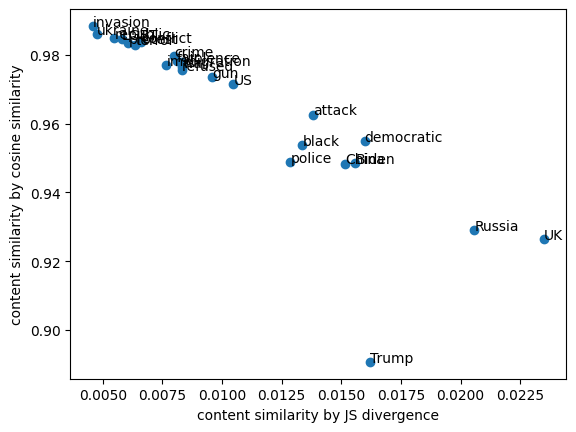

In [57]:
plt.scatter(t_js_list, t_cos_list)
for i in range(len(topics)):
    plt.annotate(topics[i], (t_js_list[i], t_cos_list[i]))
plt.xlabel('content similarity by JS divergence')
plt.ylabel('content similarity by cosine similarity')

In [50]:
pd.DataFrame({
    'mean_simi': mean_list,
    'JS_div': t_js_list,
    'Cos_div': t_cos_list,
    't_cnn': t_cnn,
    't_nypost': t_nypost
},
    index=topics
).to_csv('./records.csv')